In [259]:
import kagglehub
import pandas as pd
import os
import numpy as np

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
print("Path to dataset files:", path)

# Build the full file path
file_path = os.path.join(path, "creditcard.csv")

# Load dataset into pandas
df = pd.read_csv(file_path)

Path to dataset files: /Users/jacksonzheng/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3


In [260]:
#Droping the Duplicates
#df.drop_duplicates(inplace=True)

X = df.drop("Class", axis=1)
y = df["Class"]
print(X.shape, y.shape)

(284807, 30) (284807,)


In [261]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, cross_val_score

#Spliting the Data into Testing and Training Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Setting up the Parameters
param = {

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': 0.4,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 37,
    'scale_pos_weight': 577

}

#Selecting the Classification model of XGBoost
model = xgb.XGBClassifier(**param)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(metrics.accuracy_score(y_test, y_pred) * 100, '%')

99.95962220427653 %


In [262]:
# Filter down to fraud-only transactions
NewX_test = X_test.copy()
NewX_test["Class"] = y_test
fraud_only = NewX_test[NewX_test["Class"] == 1]

X_fraud = fraud_only.drop("Class", axis=1)
y_fraud = fraud_only["Class"]

# Predictions on fraud-only subset
y_pred_fraud = model.predict(X_fraud)

#Finding the accuracy given that all test case presented was fraudulent
print("Fraud-only detection rate:", metrics.accuracy_score(y_fraud, y_pred_fraud) * 100, "%")

from sklearn.metrics import precision_score, recall_score, f1_score

print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))  # same as fraud-only accuracy
print("F1 Score:", f1_score(y_test, y_pred))


Fraud-only detection rate: 82.6530612244898 %
Precision: 0.9310344827586207
Recall: 0.826530612244898
F1 Score: 0.8756756756756757


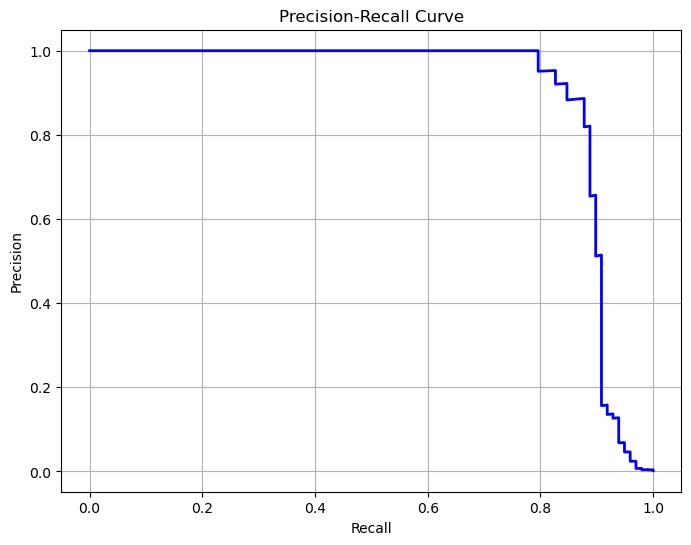

In [263]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Compute precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Plot
plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='b', lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()


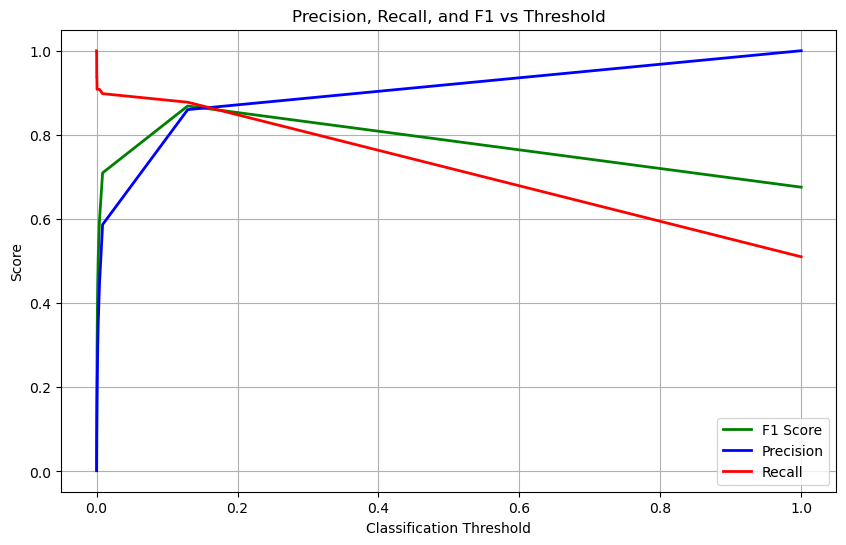

In [264]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score, make_scorer

# Get predicted probabilities for the positive class
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_true = y_test.values

# Compute precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)

# Sample thresholds to speed up plotting (every 50th point)
thresholds_sampled = thresholds[::50]

# Compute F1 for sampled thresholds
f1_scores = []
for t in thresholds_sampled:
    y_pred_thresh = (y_pred_proba >= t).astype(int)
    tp = np.sum((y_pred_thresh == 1) & (y_true == 1))
    fp = np.sum((y_pred_thresh == 1) & (y_true == 0))
    fn = np.sum((y_pred_thresh == 0) & (y_true == 1))
    f1 = 2 * tp / (2 * tp + fp + fn) if (2*tp + fp + fn) != 0 else 0
    f1_scores.append(f1)

# Plot Precision, Recall, and F1 vs Threshold
plt.figure(figsize=(10,6))
plt.plot(thresholds_sampled, f1_scores, label="F1 Score", color="green", lw=2)
plt.plot(thresholds_sampled, [precision[np.searchsorted(thresholds, t)] for t in thresholds_sampled],
         label="Precision", color="blue", lw=2)
plt.plot(thresholds_sampled, [recall[np.searchsorted(thresholds, t)] for t in thresholds_sampled],
         label="Recall", color="red", lw=2)

plt.xlabel("Classification Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1 vs Threshold")
plt.legend()
plt.grid(True)
plt.show()



In [265]:
# 5-fold stratified CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scorer = make_scorer(f1_score)
scores = cross_val_score(model, X, y, cv=skf, scoring=f1_scorer)
print("F1 scores for each fold:", scores)
print("Average F1 score:", scores.mean())

F1 scores for each fold: [0.84102564 0.91803279 0.87234043 0.84946237 0.84375   ]
Average F1 score: 0.8649222438068399


In [ ]:
X = pd.drop("Class", axis=1)
y = pd["Class"]
X = pd.drop_duplicates(X)

print(X)

print(X.shape)
print(y.shape)